In [1]:
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# DDPM

In [3]:
# Hyperparams
BATCH_SIZE = 128  # according to the paper

In [4]:
# CIFAR10
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,)),
#     transforms.RandomHorizontalFlip()  # p=0.5 by default
# ])

# train = datasets.CIFAR10("../data", train=True, download=True, transform=transform)
# test = datasets.CIFAR10("../data", train=False, download=True, transform=transform)

# train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
# MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train = datasets.MNIST("../data", train=True, download=True, transform=transform) # 28x28 resolution
test = datasets.MNIST("../data", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

Testing UNET

2.9.1+cu128
3.10.8
cuda:0


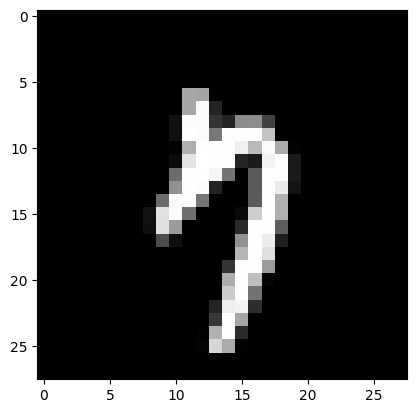

In [6]:
from ddpm import Unet

dataiter = iter(train_loader)
image,label = next(dataiter)
#plt.imshow(image[0].squeeze().numpy(),cmap='gray')
plt.imshow(image[0][0].numpy(),cmap='gray')
plt.show()

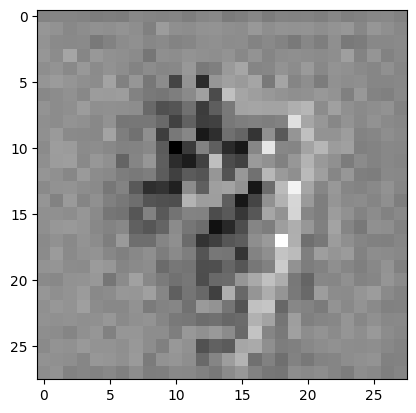

In [7]:
model = Unet(1)
output = model(image[0].unsqueeze(0), t=torch.tensor([1]))
plt.imshow(output.squeeze().squeeze().detach().numpy(),cmap='gray')
plt.show()

In [8]:
from ddpm import DDPM
model = DDPM()

In [9]:
# train
LR = 2e-3
NUM_EPOCH = 1
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=LR)

for epoch in range(NUM_EPOCH):
    model.train()
    tot_loss=0.0
    
    for images,_ in train_loader:
        images=images.to(device)
        optimizer.zero_grad()  #zero gradients
        pred_noise, true_noise = model(images)
        print(pred_noise.size())
        print(images.size())
        loss = model.loss()
        loss.backward() #backprop
        optimizer.step()#update weights
        tot_loss+=loss.item()#accumulate loss
        
with torch.no_grad():
    for images, _ in test_loader:
        images=images.to(device)
        pred_noise, true_noise=model(images)
        loss=model.loss(pred_noise, true_noise)
        test_loss+=loss.item()

print(f"Test Loss:,{test_loss:.4f}")

# Visualize Reconstructions
test_images, _ = next(iter(test_loader))
with torch.no_grad():
    reconstructions = model(test_images.to(device))

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 8, figsize=(12, 4))
for i in range(8):
    axes[0, i].imshow(test_images[i][0].cpu().numpy(), cmap='gray')
    axes[1, i].imshow(reconstructions[i][0].cpu().detach().numpy(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].axis('off')

RuntimeError: Expected all tensors to be on the same device, but got mat1 is on cuda:0, different from other tensors on cpu (when checking argument in method wrapper_CUDA_addmm)

# VAE

In [ ]:
import torch
import vae
from vae import VAE 
# Synthetic forward-pass test (no dataset)
LATENT_DIM=64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vae_model = VAE(1,LATENT_DIM).to(device)

output = vae_model(image[0].unsqueeze(0).to(device))[0]
plt.imshow(output.squeeze().squeeze().detach().cpu().numpy(),cmap='gray')
plt.show()


In [ ]:
#Hyperparams
LR=2e-3
NUM_EPOCHS=1
optimizer = optim.Adam(vae_model.parameters(),lr=LR)

for epoch in range(NUM_EPOCHS):
    vae_model.train()
    tot_loss=0.0
    
    for images,_ in train_loader:
        images=images.to(device)
        optimizer.zero_grad()#zero gradients
        recon,mean,logvar = vae_model(images)
        print(recon.size())
        print(images.size())
        loss = vae_model.loss(recon,images,mean,logvar,beta=1.0)
        loss.backward() #backprop
        optimizer.step()#update weights
        tot_loss+=loss.item()#accumulate loss
        
with torch.no_grad():
    for images, _ in test_loader:
        images=images.to(device)
        recon=vae_model(images)
        mean,logvar=model.encode(images)
        loss=model.loss(recon, images, mean, logvar, beta=1.0)
        test_loss+=loss.item()

print(f"Test Loss:,{test_loss:.4f}")

# Visualize Reconstructions
test_images, _ = next(iter(test_loader))
with torch.no_grad():
    reconstructions = vae_model(test_images.to(device))

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 8, figsize=(12, 4))
for i in range(8):
    axes[0, i].imshow(test_images[i][0].cpu().numpy(), cmap='gray')
    axes[1, i].imshow(reconstructions[i][0].cpu().detach().numpy(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].axis('off')


# LDM